In [1]:
!pip install patchify

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.utils import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import numpy as np
import tifffile as tiff
import tensorflow as tf
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import random

2025-05-24 09:48:11.939616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748080092.110904      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748080092.162315      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Download latest version
path = kagglehub.dataset_download("kmader/electron-microscopy-3d-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electron-microscopy-3d-segmentation


# Creating Dataset

In [4]:
# ===============================
# 1. Load TIF Volumes
# ===============================
train_vol = tiff.imread('/kaggle/input/electron-microscopy-3d-segmentation/training.tif')           # (N, H, W)
train_mask_vol = tiff.imread('/kaggle/input/electron-microscopy-3d-segmentation/training_groundtruth.tif')
test_vol = tiff.imread('/kaggle/input/electron-microscopy-3d-segmentation/testing.tif')
test_mask_vol = tiff.imread('/kaggle/input/electron-microscopy-3d-segmentation/testing_groundtruth.tif')

# ===============================
# 2. Combine Volumes for Patching
# ===============================
all_volumes = np.concatenate((train_vol, test_vol), axis=0)
all_masks = np.concatenate((train_mask_vol, test_mask_vol), axis=0)

# ===============================
# 3. Patchify and Normalize
# ===============================
def patchify_volume(volume, is_mask=False):
    patches = []
    for i in range(volume.shape[0]):
        img = volume[i]
        patch_set = patchify(img, (256, 256), step=256)
        for r in range(patch_set.shape[0]):
            for c in range(patch_set.shape[1]):
                patch = patch_set[r, c, :, :]
                if is_mask:
                    patch = patch / 255.0
                    patch = np.where(patch > 0.5, 1.0, 0.0).astype('float32')
                else:
                    patch = patch.astype('float32') / 255.0
                patches.append(patch)
    return np.array(patches)

all_images = patchify_volume(all_volumes, is_mask=False)
all_masks = patchify_volume(all_masks, is_mask=True)

# ===============================
# 4. Expand dims for CNN input
# ===============================
all_images = np.expand_dims(all_images, axis=-1)   # (N, 256, 256, 1)
all_masks  = np.expand_dims(all_masks, axis=-1)

# ===============================
# 5. Shuffle and Split (594 val, 594 test, rest train)
# ===============================
total_patches = all_images.shape[0]
indices = list(range(total_patches))
random.shuffle(indices)

val_size = 594
test_size = 594

val_idx = indices[:val_size]
test_idx = indices[val_size:val_size + test_size]
train_idx = indices[val_size + test_size:]

# Final datasets
train_images = all_images[train_idx]
train_masks  = all_masks[train_idx]

val_images = all_images[val_idx]
val_masks  = all_masks[val_idx]

test_images = all_images[test_idx]
test_masks  = all_masks[test_idx]

# ===============================
# 6. Confirm Shapes
# ===============================
print("Train Images:", train_images.shape)
print("Train Masks :", train_masks.shape)
print("Val Images  :", val_images.shape)
print("Val Masks   :", val_masks.shape)
print("Test Images :", test_images.shape)
print("Test Masks  :", test_masks.shape)

Train Images: (2772, 256, 256, 1)
Train Masks : (2772, 256, 256, 1)
Val Images  : (594, 256, 256, 1)
Val Masks   : (594, 256, 256, 1)
Test Images : (594, 256, 256, 1)
Test Masks  : (594, 256, 256, 1)


# Visualising 

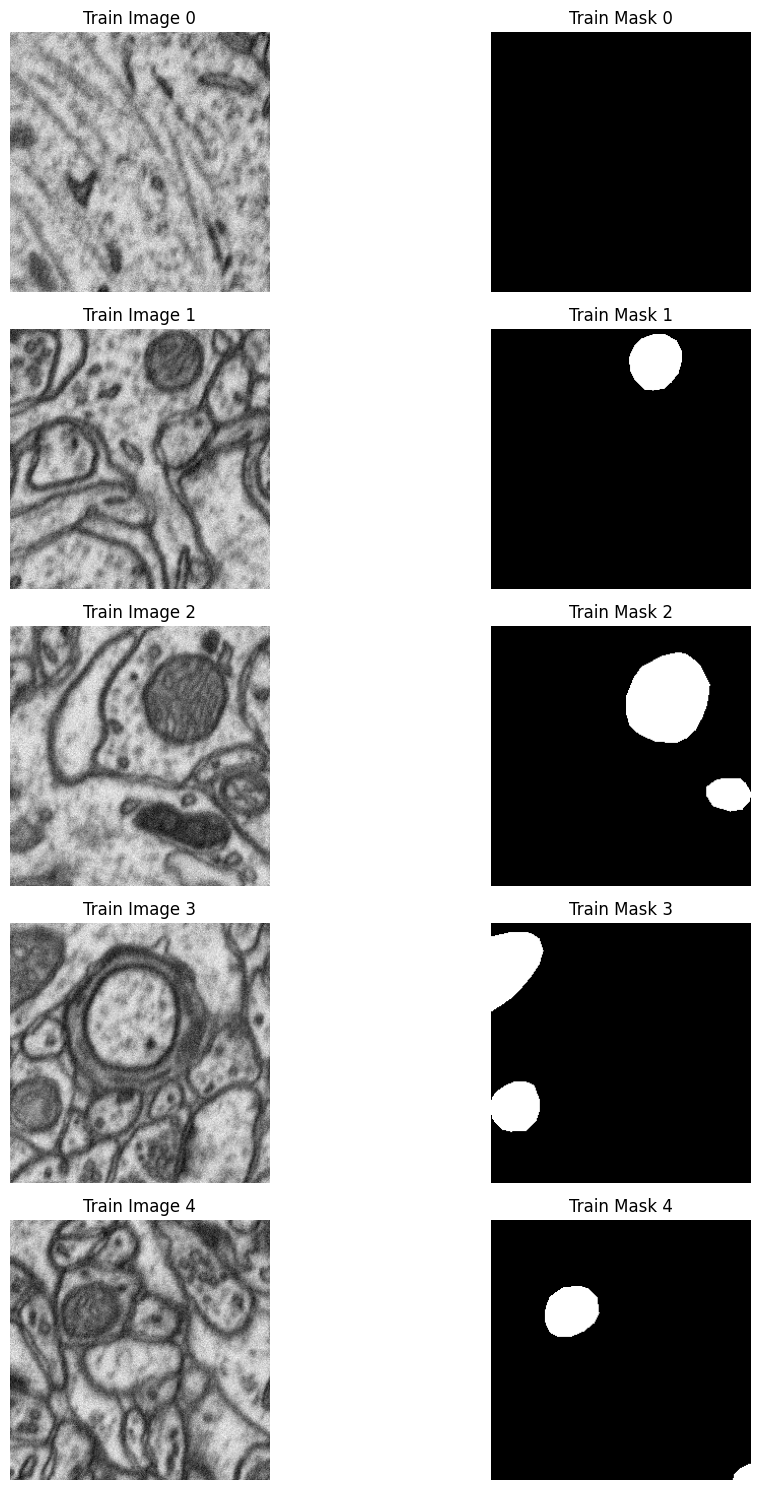

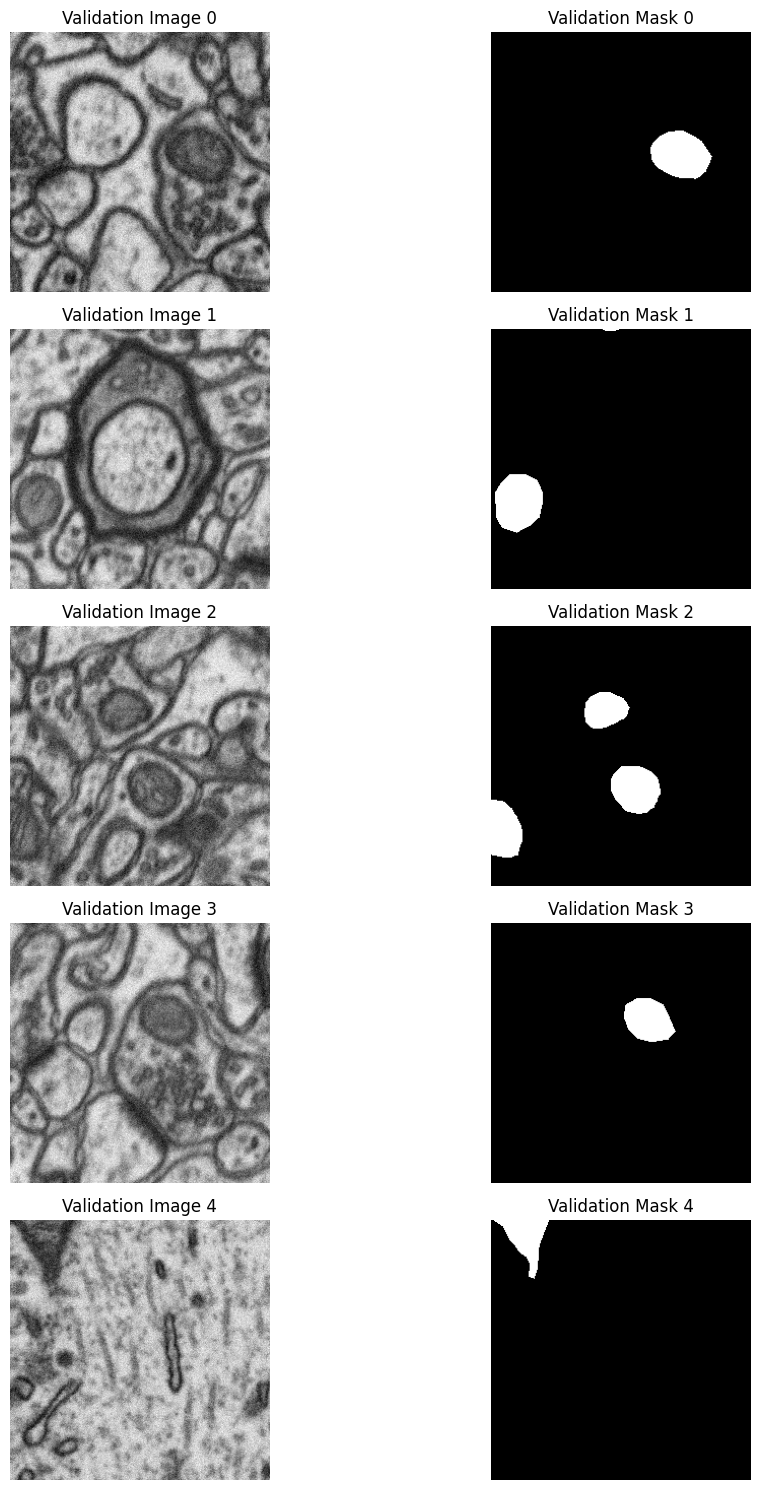

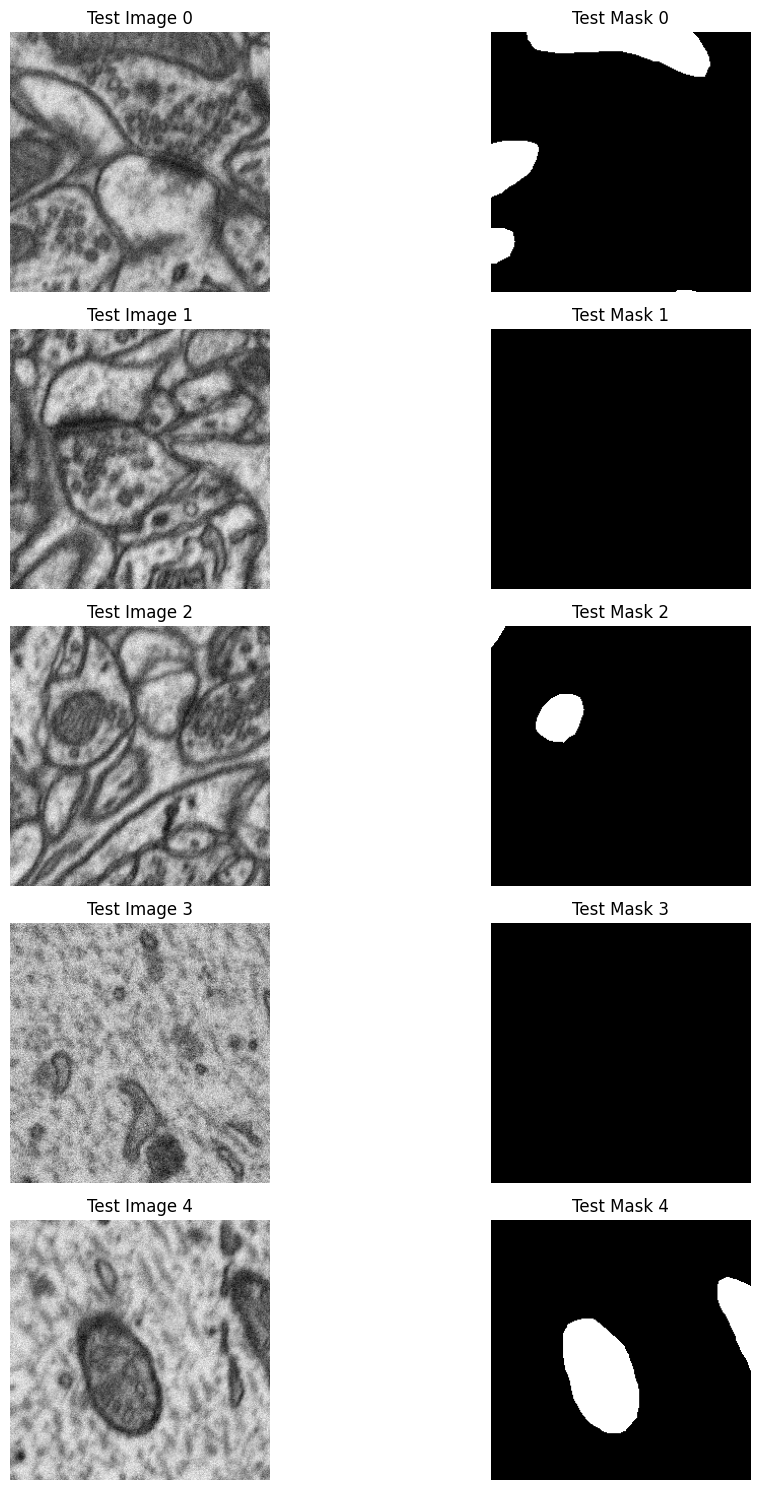

In [5]:
def visualize_samples(images, masks, num_samples=5, dataset_name="Train"):
    plt.figure(figsize=(12, num_samples * 3))
    
    for i in range(num_samples):
        img = images[i, :, :, 0]   # remove channel dimension
        mask = masks[i, :, :, 0]
        
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{dataset_name} Image {i}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{dataset_name} Mask {i}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize first 5 training images and masks
visualize_samples(train_images, train_masks, num_samples=5, dataset_name="Train")

# Visualize first 5 validation images and masks
visualize_samples(val_images, val_masks, num_samples=5, dataset_name="Validation")

# Visualize first 5 test images and masks
visualize_samples(test_images, test_masks, num_samples=5, dataset_name="Test")

# U-Net Model

In [6]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [7]:
# Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

In [8]:
# Decoder block
# skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [9]:
# Build Unet using the blocks

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Start training

In [10]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

In [11]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1748080120.068404      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [12]:
seed = 42
batch_size = 8

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) # Binarize the output again. 

In [13]:
# Create ImageDataGenerators for images and masks
image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

In [14]:
# Create generators for train images and masks
image_generator = image_data_generator.flow(
    train_images, seed=seed, batch_size=batch_size)

mask_generator = mask_data_generator.flow(
    train_masks, seed=seed, batch_size=batch_size)

In [15]:
# Create generators for validation images and masks (usually no augmentation here)
val_image_generator = ImageDataGenerator().flow(
    val_images, seed=seed, batch_size=batch_size)

val_mask_generator = ImageDataGenerator().flow(
    val_masks, seed=seed, batch_size=batch_size)

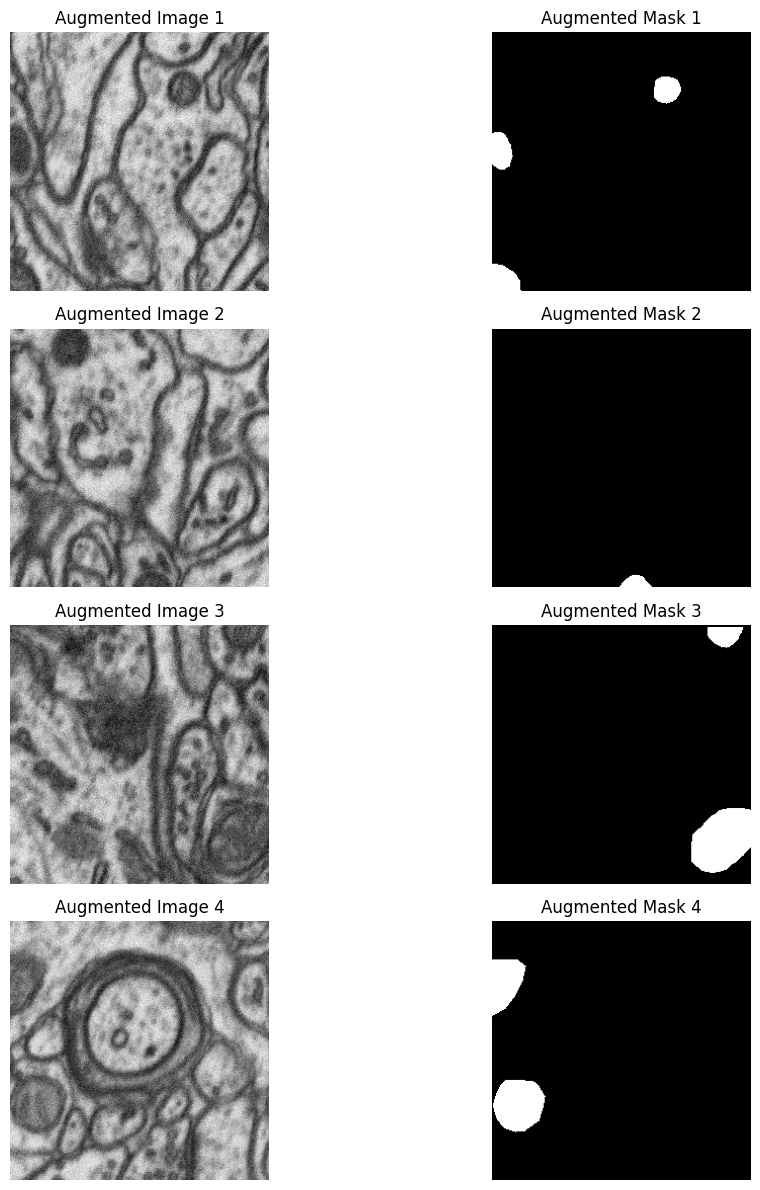

In [16]:
# Use next() function, not .next()
imgs = next(val_image_generator)
masks = next(val_mask_generator)

num_samples = min(4, imgs.shape[0])

plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title(f'Augmented Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

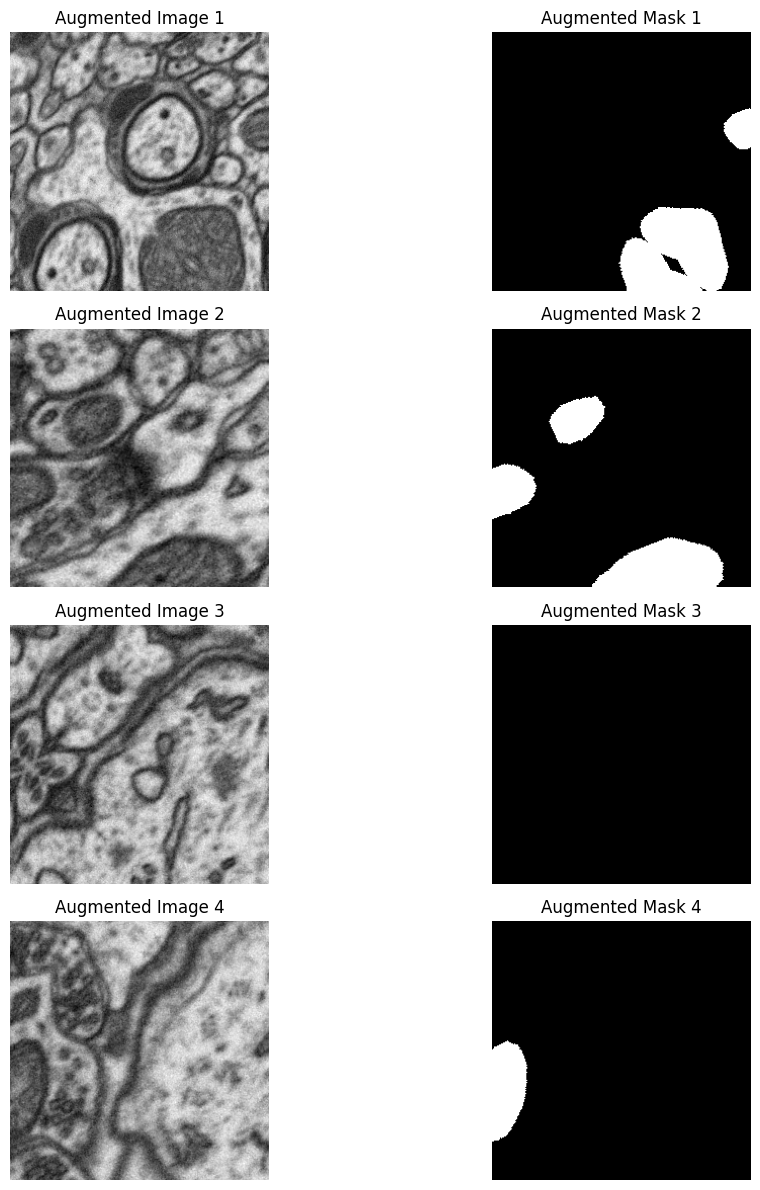

In [17]:
# Use next() function, not .next()
imgs = next(image_generator)
masks = next(mask_generator)

num_samples = min(4, imgs.shape[0])

plt.figure(figsize=(12, num_samples * 3))

for i in range(num_samples):
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')
    
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title(f'Augmented Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Combine image and mask generators to yield image-mask pairs
def my_image_mask_generator(image_gen, mask_gen):
    train_gen = zip(image_gen, mask_gen)
    for (img, mask) in train_gen:
        yield (img, mask)


train_generator = my_image_mask_generator(image_generator, mask_generator)
validation_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

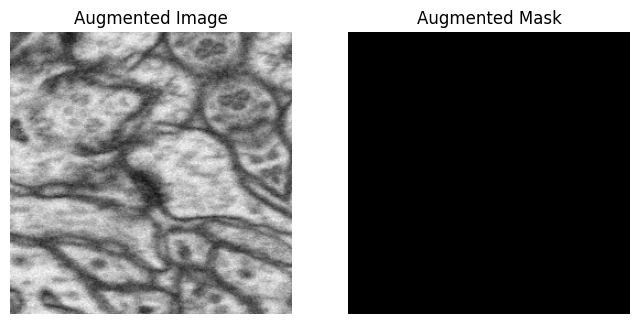

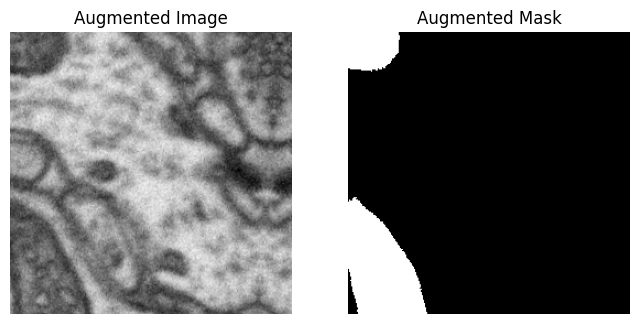

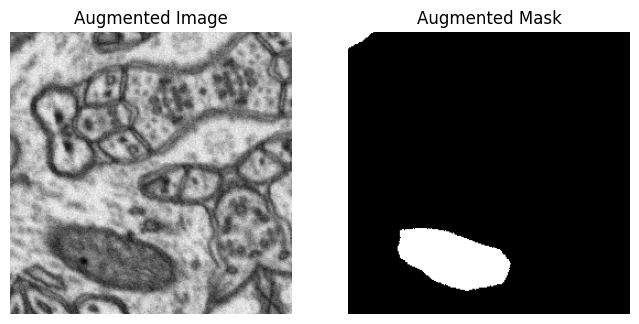

In [19]:
# Visualize one batch of augmented images and masks
x_batch, y_batch = next(train_generator)
for i in range(min(batch_size, 3)):  # show 3 samples max
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(x_batch[i,:,:,0], cmap='gray')
    plt.title('Augmented Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(y_batch[i,:,:,0], cmap='gray')
    plt.title('Augmented Mask')
    plt.axis('off')
    plt.show()

In [20]:
# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(val_images) // batch_size

# Finally, train your model using the generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

Epoch 1/10


I0000 00:00:1748080142.793680      67 service.cc:148] XLA service 0x7c8e24002570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748080142.794420      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748080144.456734      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748080168.608527      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


344/346 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9439 - loss: 0.1594

E0000 00:00:1748080244.156585      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748080244.418524      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748080244.674802      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-24 09:50:44.851312: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[4,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{

346/346 ━━━━━━━━━━━━━━━━━━━━ 145s 293ms/step - accuracy: 0.9441 - loss: 0.1589 - val_accuracy: 0.9472 - val_loss: 0.1319
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.9791 - loss: 0.0572 - val_accuracy: 0.9727 - val_loss: 0.0835
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.9814 - loss: 0.0486 - val_accuracy: 0.9872 - val_loss: 0.0352
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.9840 - loss: 0.0425 - val_accuracy: 0.9694 - val_loss: 0.0801
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.9861 - loss: 0.0372 - val_accuracy: 0.9872 - val_loss: 0.0339
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 225ms/step - accuracy: 0.9866 - loss: 0.0355 - val_accuracy: 0.9871 - val_loss: 0.0364
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.9881 - loss: 0.0314 - val_accuracy: 0.9849 - val_loss: 0.0395
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.9880 - loss: 0.0314 - va

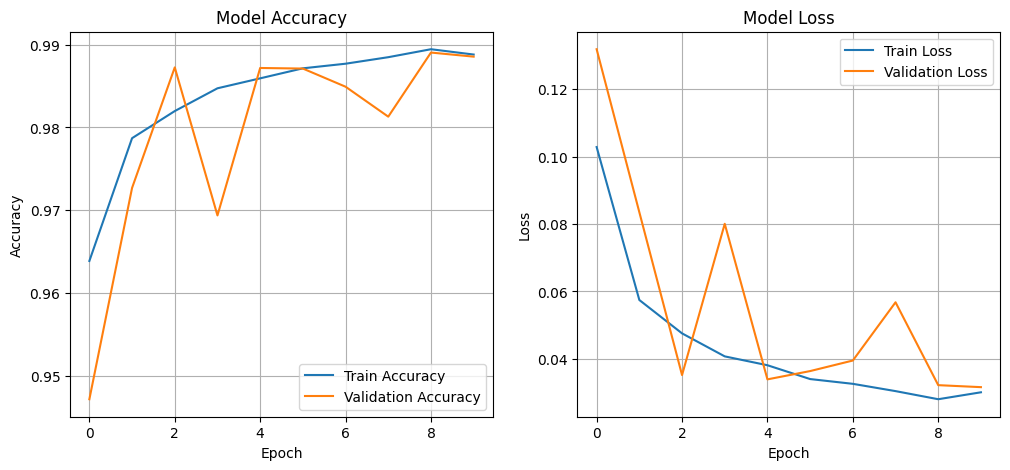

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [22]:
# Predict on test images
y_pred = model.predict(test_images)

# Threshold predictions to binary masks
y_pred_thresholded = y_pred > 0.5

# Binarize ground truth masks as well (to be safe)
test_masks_bin = np.where(test_masks > 0.5, 1, 0)

# Calculate IoU score
intersection = np.logical_and(test_masks_bin, y_pred_thresholded)
union = np.logical_or(test_masks_bin, y_pred_thresholded)

iou_score = np.sum(intersection) / (np.sum(union) + 1e-7)  # epsilon added to avoid division by zero
print("IoU score is:", iou_score)

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step

E0000 00:00:1748081002.697741      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748081002.936327      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748081003.179239      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748081004.311838      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748081004.579350      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step
IoU score is: 0.7938386405221155


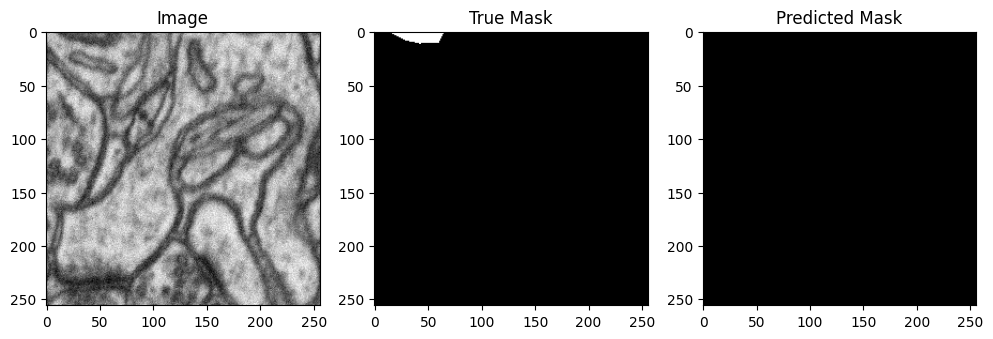

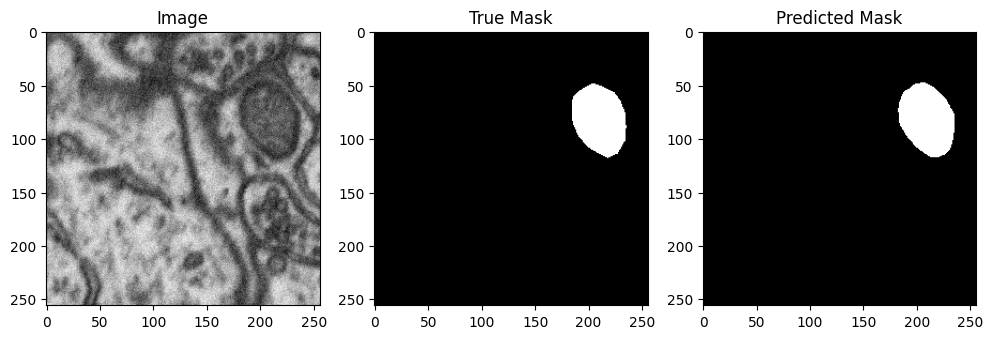

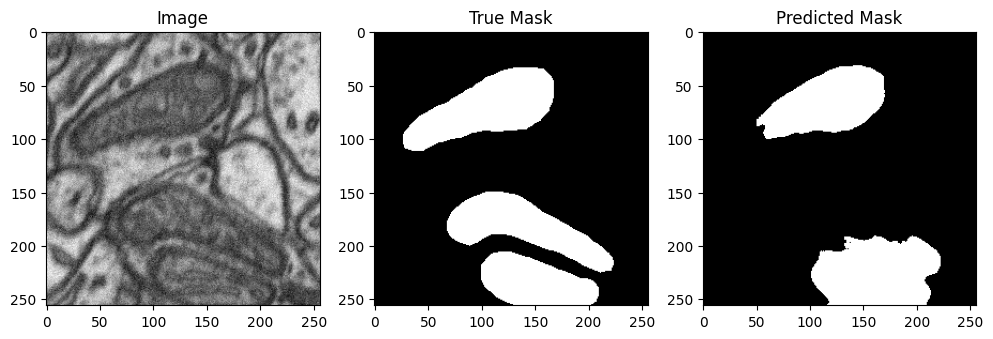

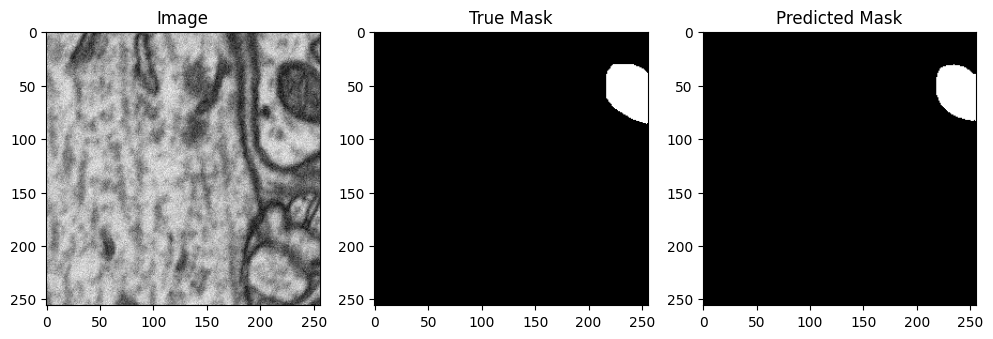

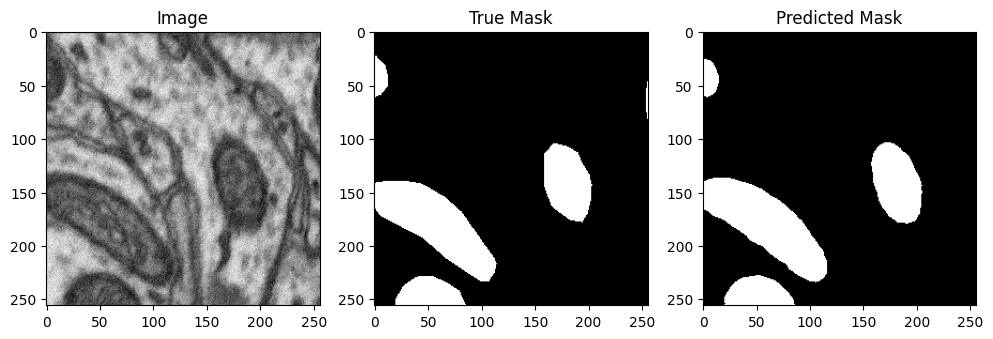

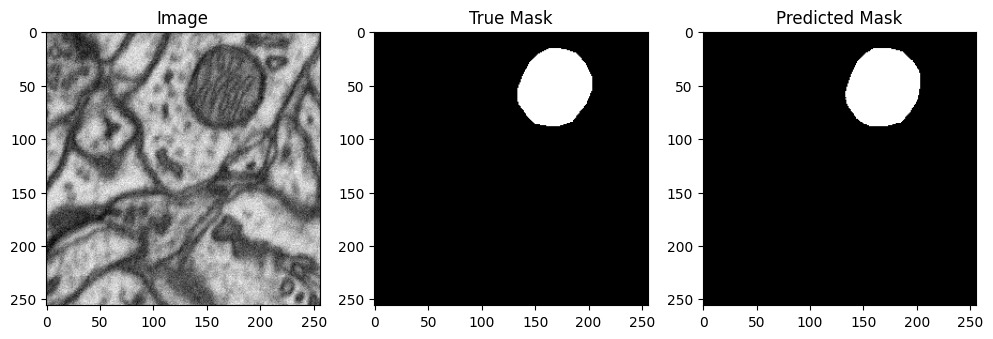

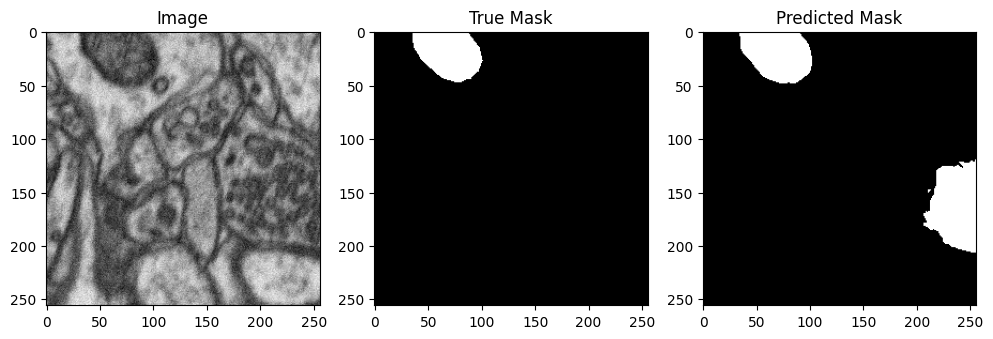

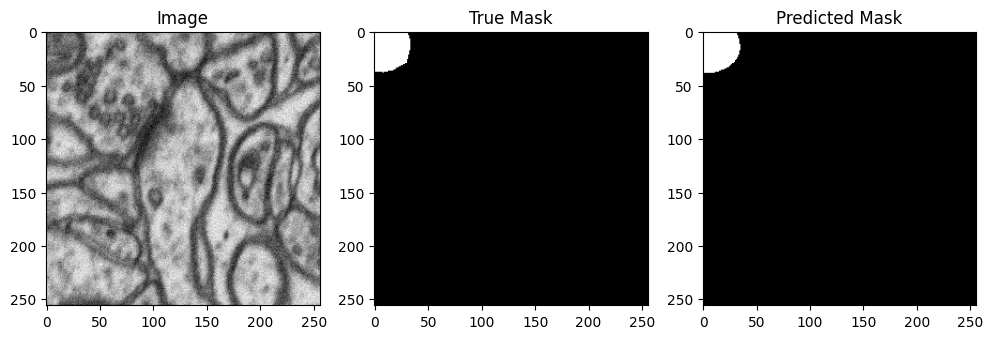

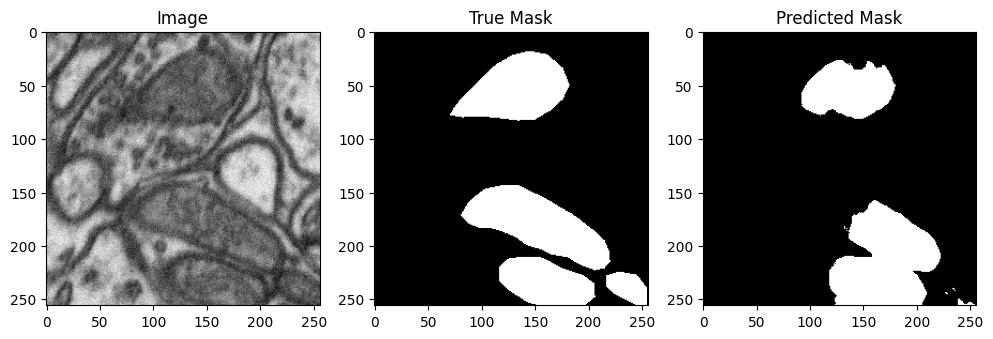

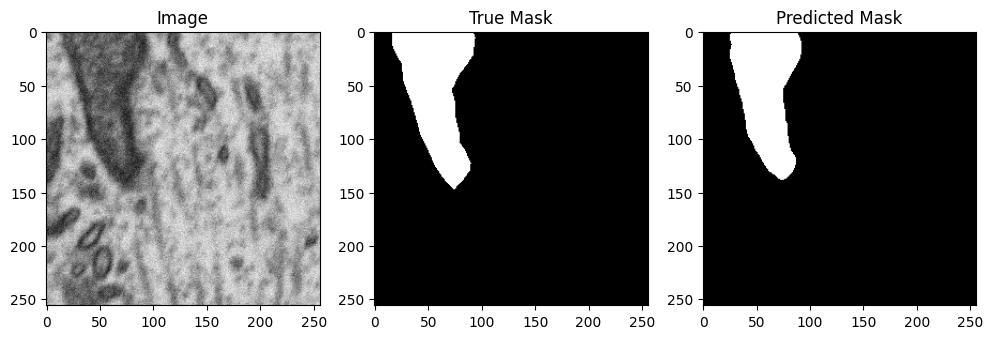

In [23]:
for i in range(10):
    idx = random.randint(0, test_images.shape[0]-1)
    image = test_images[idx, :, :, 0]
    true_mask = test_masks[idx, :, :, 0]
    pred_mask = y_pred_thresholded[idx, :, :, 0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image, cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    
    plt.show()

In [24]:
def reconstruct_volume_from_patches(patches, volume_shape, patch_size=(256, 256)):
    """
    Reconstruct a volume from patches.
    :param patches: (N_patches, 256, 256, 1)
    :param volume_shape: (slices, height, width)
    """
    from patchify import unpatchify

    patches_per_slice = (volume_shape[1] // patch_size[0]) * (volume_shape[2] // patch_size[1])
    num_slices = patches.shape[0] // patches_per_slice

    reconstructed_volume = []
    for i in range(num_slices):
        start = i * patches_per_slice
        end = start + patches_per_slice
        slice_patches = patches[start:end, :, :, 0]  # drop channel for unpatchify
        slice_patches = slice_patches.reshape(volume_shape[1] // 256, volume_shape[2] // 256, 256, 256)
        reconstructed_slice = unpatchify(slice_patches, (volume_shape[1], volume_shape[2]))
        reconstructed_volume.append(reconstructed_slice)

    return np.array(reconstructed_volume)

In [25]:
# Reconstruct image and mask volumes
original_test_shape = test_vol.shape  # e.g. (10, 512, 512)

recon_test_images = reconstruct_volume_from_patches(test_images, original_test_shape)
recon_test_masks = reconstruct_volume_from_patches(test_masks, original_test_shape)
recon_pred_masks = reconstruct_volume_from_patches(y_pred_thresholded, original_test_shape)

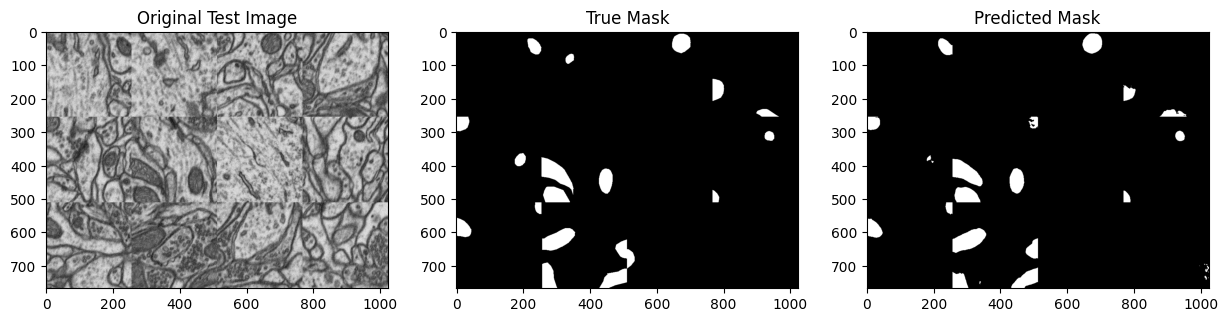

In [26]:
idx = 5  # pick a slice index

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Test Image")
plt.imshow(recon_test_images[idx], cmap='gray')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(recon_test_masks[idx], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(recon_pred_masks[idx], cmap='gray')

plt.show()